# Causal Transparency Framework - COMPAS Example

This notebook demonstrates the application of the Causal Transparency Framework (CTF) to the COMPAS recidivism dataset, focusing on fairness and bias analysis.

## Overview

The CTF provides a structured approach to evaluating and enhancing model transparency through causal reasoning. In this example with the COMPAS dataset, we'll focus on:

1. Discovering causal relationships in recidivism prediction
2. Evaluating racial bias through causal lens
3. Comparing standard and causal models for fairness
4. Analyzing counterfactual explanations across demographic groups

This allows us to understand how the CTF can help identify and mitigate algorithmic bias in criminal justice applications.

In [ ]:
# Import path utility first to ensure CTF can be imported
import sys
from notebook_utils import add_ctf_to_path

# Add repository root to path
add_ctf_to_path()

# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import CTF components
from ctf.framework import CausalTransparencyFramework
from ctf.causal_discovery import CausalDiscovery
from ctf.transparency_metrics import TransparencyMetrics

# Set random seed for reproducibility
np.random.seed(42)

## 1. Data Loading and Preprocessing

First, we'll load the processed COMPAS dataset. This dataset contains information about defendants and recidivism prediction.

In [4]:
# Path to the processed COMPAS dataset
data_path = "../data/processed_compas_data.csv"

# Check if the file exists
if not os.path.exists(data_path):
    print(f"Warning: {data_path} not found.")
    print("Please download the processed COMPAS dataset or update the path.")
    
    # For demonstration purposes, we'll create a small synthetic dataset
    print("Creating synthetic dataset for demonstration...")
    
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Create synthetic data
    n_samples = 1000
    
    # Create demographics features
    age = np.random.normal(35, 10, n_samples)
    age = np.clip(age, 18, 70)
    
    # Create race variables with bias
    race_african_american = np.random.binomial(1, 0.5, n_samples)
    race_caucasian = 1 - race_african_american
    
    # Create gender variables
    gender_male = np.random.binomial(1, 0.8, n_samples)
    gender_female = 1 - gender_male
    
    # Create priors count (slightly higher for African Americans due to systemic bias)
    base_priors = np.random.poisson(2, n_samples)
    race_effect = race_african_american * np.random.binomial(1, 0.3, n_samples)
    priors_count = base_priors + race_effect
    
    # Create charge degree
    charge_degree_f = np.random.binomial(1, 0.3, n_samples)
    charge_degree_m = 1 - charge_degree_f
    
    # Create recidivism (target - influenced by age, priors, with racial bias)
    logits = -3 + 0.7 * priors_count - 0.03 * age + 0.3 * race_african_american
    p_recid = 1 / (1 + np.exp(-logits))
    two_year_recid = np.random.binomial(1, p_recid)
    
    # Create DataFrame
    df = pd.DataFrame({
        'age': age,
        'race_African-American': race_african_american,
        'race_Caucasian': race_caucasian,
        'sex_Female': gender_female,
        'sex_Male': gender_male,
        'priors_count': priors_count,
        'c_charge_degree_F': charge_degree_f,
        'c_charge_degree_M': charge_degree_m,
        'two_year_recid': two_year_recid
    })
    
    # Save synthetic data
    os.makedirs(os.path.dirname(data_path), exist_ok=True)
    df.to_csv(data_path, index=False)
    print(f"Synthetic dataset created and saved to {data_path}")
else:
    # Load the real dataset
    df = pd.read_csv(data_path)
    print(f"Loaded COMPAS dataset with {df.shape[0]} samples and {df.shape[1]} features")

Please download the processed COMPAS dataset or update the path.
Creating synthetic dataset for demonstration...
Synthetic dataset created and saved to ../data/processed_compas_data.csv


In [6]:
# Explore the dataset
print("Dataset columns:")
print(df.columns.tolist())

print("\nDataset summary:")
df.describe()

Dataset columns:
['age', 'race_African-American', 'race_Caucasian', 'sex_Female', 'sex_Male', 'priors_count', 'c_charge_degree_F', 'c_charge_degree_M', 'two_year_recid']

Dataset summary:


,age,race_African-American,race_Caucasian,sex_Female,sex_Male,priors_count,c_charge_degree_F,c_charge_degree_M,two_year_recid
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.316459,0.515000,0.485000,0.19200,0.80800,2.125000,0.260000,0.740000,0.117000
std,9.507432,0.500025,0.500025,0.39407,0.39407,1.407607,0.438854,0.438854,0.321581
min,18.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,28.524097,0.000000,0.000000,0.00000,1.00000,1.000000,0.000000,0.000000,0.000000
50%,35.253006,1.000000,0.000000,0.00000,1.00000,2.000000,0.000000,1.000000,0.000000
75%,41.479439,1.000000,1.000000,0.00000,1.00000,3.000000,1.000000,1.000000,0.000000
max,70.000000,1.000000,1.000000,1.00000,1.00000,7.000000,1.000000,1.000000,1.000000



Target (recidivism) distribution:
0    0.883
1    0.117
Name: two_year_recid, dtype: float64


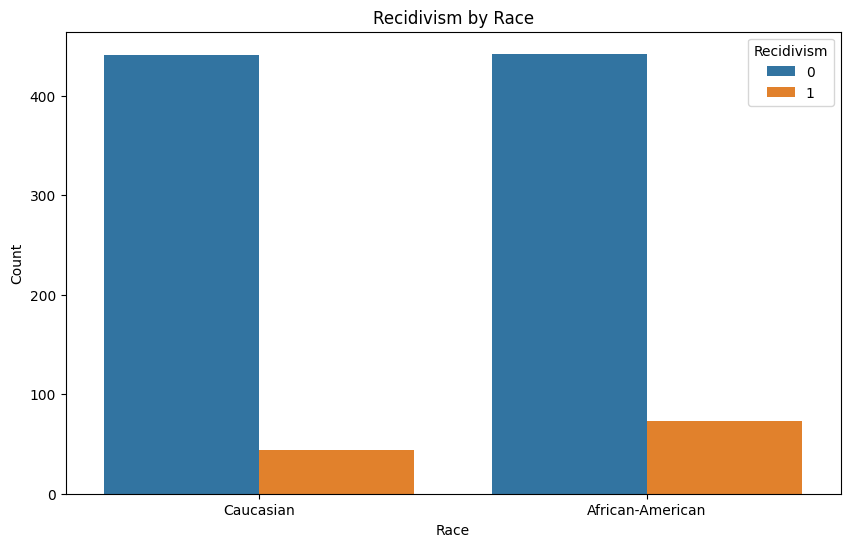


Recidivism rates by race:
race
African-American    0.141748
Caucasian           0.090722
Name: two_year_recid, dtype: float64


In [8]:
# Check target distribution
print("\nTarget (recidivism) distribution:")
print(df['two_year_recid'].value_counts(normalize=True))

# Visualize target distribution by race
plt.figure(figsize=(10, 6))

# Create a combined race column for visualization
if 'race_African-American' in df.columns and 'race_Caucasian' in df.columns:
    df['race'] = np.where(df['race_African-American'] == 1, 'African-American', 'Caucasian')
    
    sns.countplot(x='race', hue='two_year_recid', data=df)
    plt.title('Recidivism by Race')
    plt.xlabel('Race')
    plt.ylabel('Count')
    plt.legend(title='Recidivism')
    plt.show()
    
    # Calculate recidivism rates by race
    recid_by_race = df.groupby('race')['two_year_recid'].mean()
    print("\nRecidivism rates by race:")
    print(recid_by_race)

## 2. Causal Transparency Framework Application

Now we'll apply the Causal Transparency Framework to analyze the dataset and train models, with a focus on fairness.

In [11]:
# Initialize the framework
ctf = CausalTransparencyFramework(
    data_path=data_path,
    target_col="two_year_recid",
    output_dir="../results/compas",
    random_state=42
)

NameError: name 'CausalTransparencyFramework' is not defined

In [13]:
# Add domain knowledge for criminal justice
domain_knowledge = {
    "edges": [
        # Domain knowledge about recidivism predictors
        # Format: [source, target, weight]
        ["priors_count", "two_year_recid", 0.8],
        ["age", "two_year_recid", 0.6],
        ["c_charge_degree_F", "two_year_recid", 0.4],
        
        # Social context edges - these represent systemic bias, not causal effects
        ["race_African-American", "priors_count", 0.3],
        
        # Other demographic relationships
        ["sex_Male", "priors_count", 0.2]
    ]
}

In [15]:
# Discover causal structure
G = ctf.discover_causal_structure(domain_knowledge=domain_knowledge)
print(f"Causal graph discovered with {len(G.nodes())} nodes and {len(G.edges())} edges")

NameError: name 'ctf' is not defined

In [17]:
# Train predictive models
models = ctf.train_models(test_size=0.2)
print(f"Trained {len(models)} models")

NameError: name 'ctf' is not defined

In [19]:
# Calculate transparency metrics
metrics = ctf.calculate_transparency_metrics()
print("Transparency metrics calculated")

NameError: name 'ctf' is not defined

In [21]:
# Generate report
report_path = ctf.generate_report()
print(f"CTF report generated at {report_path}")

NameError: name 'ctf' is not defined

## 3. Fairness Analysis

Now let's analyze the fairness implications of the models by examining how they treat different racial groups.

In [24]:
# Split test data by race
X_test, y_test = ctf.test_data

# Add race information back to test data
X_test_with_race = X_test.copy()
X_test_with_race['two_year_recid'] = y_test

# Split by race
if 'race_African-American' in X_test.columns and 'race_Caucasian' in X_test.columns:
    X_test_african_american = X_test[X_test['race_African-American'] == 1]
    y_test_african_american = y_test[X_test['race_African-American'] == 1]
    
    X_test_caucasian = X_test[X_test['race_Caucasian'] == 1]
    y_test_caucasian = y_test[X_test['race_Caucasian'] == 1]
    
    print(f"Test data: {len(X_test_african_american)} African American, {len(X_test_caucasian)} Caucasian")

NameError: name 'ctf' is not defined

In [26]:
# Calculate fairness metrics for each model
fairness_metrics = {}

for model_name, model in ctf.models.items():
    print(f"\nCalculating fairness metrics for {model_name}...")
    
    # Get features used by this model
    if model_name.startswith('causal_'):
        # Get causal parents
        parents = list(ctf.causal_graph.predecessors(ctf.target_col))
        features = [p for p in parents if p in X_test.columns]
    else:
        # Use all features
        features = X_test.columns.tolist()
    
    # Calculate predictions for each group
    if 'race_African-American' in X_test.columns and 'race_Caucasian' in X_test.columns:
        # African American predictions
        X_aa = X_test_african_american[features]
        y_aa_pred = model.predict(X_aa)
        y_aa_pred_proba = model.predict_proba(X_aa)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Caucasian predictions
        X_c = X_test_caucasian[features]
        y_c_pred = model.predict(X_c)
        y_c_pred_proba = model.predict_proba(X_c)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Calculate metrics
        from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
        
        # Accuracy by race
        aa_accuracy = accuracy_score(y_test_african_american, y_aa_pred)
        c_accuracy = accuracy_score(y_test_caucasian, y_c_pred)
        accuracy_gap = abs(aa_accuracy - c_accuracy)
        
        # Prediction rates by race
        aa_pred_rate = np.mean(y_aa_pred)
        c_pred_rate = np.mean(y_c_pred)
        pred_rate_gap = abs(aa_pred_rate - c_pred_rate)
        
        # True positive rates
        aa_tpr = np.mean(y_aa_pred[y_test_african_american == 1]) if sum(y_test_african_american) > 0 else 0
        c_tpr = np.mean(y_c_pred[y_test_caucasian == 1]) if sum(y_test_caucasian) > 0 else 0
        tpr_gap = abs(aa_tpr - c_tpr)
        
        # False positive rates
        aa_fpr = np.mean(y_aa_pred[y_test_african_american == 0]) if sum(y_test_african_american == 0) > 0 else 0
        c_fpr = np.mean(y_c_pred[y_test_caucasian == 0]) if sum(y_test_caucasian == 0) > 0 else 0
        fpr_gap = abs(aa_fpr - c_fpr)
        
        # AUC by race
        if y_aa_pred_proba is not None and y_c_pred_proba is not None:
            try:
                aa_auc = roc_auc_score(y_test_african_american, y_aa_pred_proba)
                c_auc = roc_auc_score(y_test_caucasian, y_c_pred_proba)
                auc_gap = abs(aa_auc - c_auc)
            except:
                aa_auc, c_auc, auc_gap = 0, 0, 0
        else:
            aa_auc, c_auc, auc_gap = 0, 0, 0
        
        # Store metrics
        fairness_metrics[model_name] = {
            'african_american_accuracy': aa_accuracy,
            'caucasian_accuracy': c_accuracy,
            'accuracy_gap': accuracy_gap,
            
            'african_american_pred_rate': aa_pred_rate,
            'caucasian_pred_rate': c_pred_rate,
            'pred_rate_gap': pred_rate_gap,
            
            'african_american_tpr': aa_tpr,
            'caucasian_tpr': c_tpr,
            'tpr_gap': tpr_gap,
            
            'african_american_fpr': aa_fpr,
            'caucasian_fpr': c_fpr,
            'fpr_gap': fpr_gap,
            
            'african_american_auc': aa_auc,
            'caucasian_auc': c_auc,
            'auc_gap': auc_gap
        }
        
        # Print summary
        print(f"  Accuracy: African American = {aa_accuracy:.4f}, Caucasian = {c_accuracy:.4f}, Gap = {accuracy_gap:.4f}")
        print(f"  Prediction Rate: African American = {aa_pred_rate:.4f}, Caucasian = {c_pred_rate:.4f}, Gap = {pred_rate_gap:.4f}")
        print(f"  TPR: African American = {aa_tpr:.4f}, Caucasian = {c_tpr:.4f}, Gap = {tpr_gap:.4f}")
        print(f"  FPR: African American = {aa_fpr:.4f}, Caucasian = {c_fpr:.4f}, Gap = {fpr_gap:.4f}")

NameError: name 'ctf' is not defined

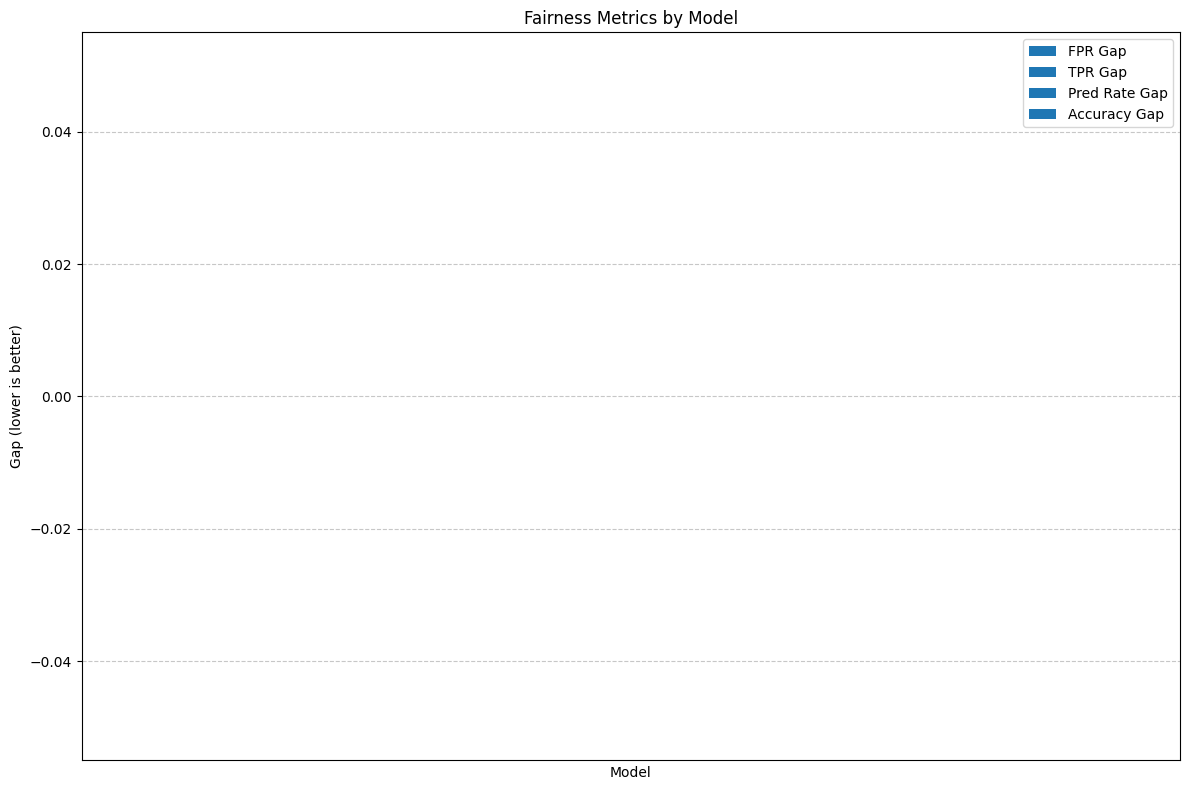

In [28]:
# Visualize fairness metrics
plt.figure(figsize=(12, 8))

# Prepare data for visualization
model_names = list(fairness_metrics.keys())
fpr_gaps = [fairness_metrics[m]['fpr_gap'] for m in model_names]
tpr_gaps = [fairness_metrics[m]['tpr_gap'] for m in model_names]
pred_rate_gaps = [fairness_metrics[m]['pred_rate_gap'] for m in model_names]
accuracy_gaps = [fairness_metrics[m]['accuracy_gap'] for m in model_names]

# Model types
model_types = ['Causal' if m.startswith('causal_') else 'Full' for m in model_names]

# Create DataFrame
fairness_df = pd.DataFrame({
    'Model': model_names,
    'FPR Gap': fpr_gaps,
    'TPR Gap': tpr_gaps,
    'Prediction Rate Gap': pred_rate_gaps,
    'Accuracy Gap': accuracy_gaps,
    'Type': model_types
})

# Plot
bar_width = 0.2
index = np.arange(len(model_names))

plt.bar(index, fpr_gaps, bar_width, label='FPR Gap', alpha=0.8)
plt.bar(index + bar_width, tpr_gaps, bar_width, label='TPR Gap', alpha=0.8)
plt.bar(index + 2*bar_width, pred_rate_gaps, bar_width, label='Pred Rate Gap', alpha=0.8)
plt.bar(index + 3*bar_width, accuracy_gaps, bar_width, label='Accuracy Gap', alpha=0.8)

plt.xlabel('Model')
plt.ylabel('Gap (lower is better)')
plt.title('Fairness Metrics by Model')
plt.xticks(index + 1.5*bar_width, model_names, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Create fairness vs. performance plot
plt.figure(figsize=(10, 6))

# Combine fairness and performance data
model_performance = pd.DataFrame({
    'Model': list(ctf.model_performance.keys()),
    'AUC': [ctf.model_performance[m]['auc'] for m in ctf.model_performance.keys()],
    'Accuracy': [ctf.model_performance[m]['accuracy'] for m in ctf.model_performance.keys()]
})

fairness_summary = pd.DataFrame({
    'Model': list(fairness_metrics.keys()),
    'FPR Gap': [fairness_metrics[m]['fpr_gap'] for m in fairness_metrics.keys()],
    'Type': ['Causal' if m.startswith('causal_') else 'Full' for m in fairness_metrics.keys()]
})

combined_df = pd.merge(model_performance, fairness_summary, on='Model')

# Create scatter plot: AUC vs. FPR Gap
sns.scatterplot(data=combined_df, x='AUC', y='FPR Gap', hue='Type', style='Type',
                s=100, palette=['#3366cc', '#cc3366'])

# Add labels
for i, row in combined_df.iterrows():
    plt.text(row['AUC'] + 0.01, row['FPR Gap'] + 0.01, row['Model'], fontsize=8)

plt.title('Performance vs. Fairness Tradeoff')
plt.xlabel('AUC (performance)')
plt.ylabel('FPR Gap (lower is better for fairness)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Analyzing Counterfactual Stability by Race

Now let's analyze the Counterfactual Stability (CS) metric, which measures how stable predictions are under small perturbations, and see if it differs by race.

In [ ]:
# Calculate CS separately for each race
cs_by_race = {}

for model_name, model in ctf.models.items():
    print(f"\nCalculating CS by race for {model_name}...")
    
    # Get features used by this model
    if model_name.startswith('causal_'):
        # Get causal parents
        parents = list(ctf.causal_graph.predecessors(ctf.target_col))
        features = [p for p in parents if p in X_test.columns]
    else:
        # Use all features
        features = X_test.columns.tolist()
    
    if 'race_African-American' in X_test.columns and 'race_Caucasian' in X_test.columns:
        # Calculate CS for African American
        if hasattr(model, 'predict_proba'):
            # Initialize TransparencyMetrics for African American
            tm_aa = TransparencyMetrics(
                causal_graph=ctf.causal_graph,
                data=df[df['race_African-American'] == 1],
                target_col=ctf.target_col,
                output_dir=os.path.join(ctf.output_dir, 'fairness')
            )
            
            # Calculate CS
            cs_aa = tm_aa.calculate_cs(model, X_test_african_american[features])
            
            # Calculate CS for Caucasian
            tm_c = TransparencyMetrics(
                causal_graph=ctf.causal_graph,
                data=df[df['race_Caucasian'] == 1],
                target_col=ctf.target_col,
                output_dir=os.path.join(ctf.output_dir, 'fairness')
            )
            
            cs_c = tm_c.calculate_cs(model, X_test_caucasian[features])
            
            # Store results
            cs_by_race[model_name] = {
                'african_american': cs_aa.get('overall', 0),
                'caucasian': cs_c.get('overall', 0),
                'gap': abs(cs_aa.get('overall', 0) - cs_c.get('overall', 0))
            }
            
            # Print results
            print(f"  CS: African American = {cs_aa.get('overall', 0):.4f}, Caucasian = {cs_c.get('overall', 0):.4f}")
            print(f"  Gap: {cs_by_race[model_name]['gap']:.4f}")

In [ ]:
# Visualize CS by race
plt.figure(figsize=(10, 6))

# Prepare data
model_names = list(cs_by_race.keys())
cs_aa = [cs_by_race[m]['african_american'] for m in model_names]
cs_c = [cs_by_race[m]['caucasian'] for m in model_names]
cs_gaps = [cs_by_race[m]['gap'] for m in model_names]
model_types = ['Causal' if m.startswith('causal_') else 'Full' for m in model_names]

# Create DataFrame
cs_df = pd.DataFrame({
    'Model': model_names,
    'African American CS': cs_aa,
    'Caucasian CS': cs_c,
    'CS Gap': cs_gaps,
    'Type': model_types
})

# Plot
bar_width = 0.3
index = np.arange(len(model_names))

plt.bar(index, cs_aa, bar_width, label='African American CS', color='#3366cc')
plt.bar(index + bar_width, cs_c, bar_width, label='Caucasian CS', color='#cc3366')

# Add line for gaps
ax2 = plt.twinx()
ax2.plot(index + bar_width/2, cs_gaps, 'ko-', label='CS Gap')
ax2.set_ylabel('CS Gap (lower is better)')
ax2.set_ylim(0, max(cs_gaps) * 1.2)

# Add labels and formatting
plt.xlabel('Model')
plt.ylabel('Counterfactual Stability (higher is better)')
plt.title('Counterfactual Stability by Race')
plt.xticks(index + bar_width/2, model_names, rotation=45, ha='right')
plt.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 5. Causal Fairness Analysis

Let's analyze the causal pathways that might be contributing to bias in the model.

In [ ]:
# Identify causal paths from race to recidivism prediction
race_features = [col for col in df.columns if 'race_' in col]
target_col = "two_year_recid"

causal_paths = {}

for race_feature in race_features:
    if race_feature in ctf.causal_graph.nodes() and target_col in ctf.causal_graph.nodes():
        # Find direct path (if any)
        direct_path = ctf.causal_graph.has_edge(race_feature, target_col)
        
        # Find all paths from race to target
        try:
            all_paths = list(nx.all_simple_paths(ctf.causal_graph, race_feature, target_col))
        except nx.NetworkXNoPath:
            all_paths = []
        
        # Store results
        causal_paths[race_feature] = {
            'direct_path': direct_path,
            'all_paths': all_paths,
            'num_paths': len(all_paths)
        }

# Print causal paths
print("Causal paths from race to recidivism:")
for race_feature, paths in causal_paths.items():
    print(f"\n{race_feature}:")
    print(f"  Direct path: {'Yes' if paths['direct_path'] else 'No'}")
    print(f"  Number of paths: {paths['num_paths']}")
    
    if paths['all_paths']:
        print("  Paths:")
        for i, path in enumerate(paths['all_paths']):
            print(f"    {i+1}. {' -> '.join(path)}")

In [ ]:
# Calculate feature importance by race for the best performing model
best_model_name = max(ctf.model_performance.keys(), 
                      key=lambda m: ctf.model_performance[m]['auc'])
best_model = ctf.models[best_model_name]

# Check if model supports feature importance
if hasattr(best_model, 'feature_importances_') or hasattr(best_model, 'coef_'):
    # Get features used by this model
    if best_model_name.startswith('causal_'):
        # Get causal parents
        parents = list(ctf.causal_graph.predecessors(ctf.target_col))
        features = [p for p in parents if p in X_test.columns]
    else:
        # Use all features
        features = X_test.columns.tolist()
    
    # Get feature importance
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
    else:
        importances = np.abs(best_model.coef_[0] if len(best_model.coef_.shape) > 1 else best_model.coef_)
    
    # Create feature importance dictionary
    feature_importance = dict(zip(features, importances))
    
    # Sort by importance
    feature_importance = dict(sorted(feature_importance.items(), key=lambda item: item[1], reverse=True))
    
    # Display feature importance
    print(f"Feature importance for {best_model_name}:")
    for feature, importance in feature_importance.items():
        print(f"  {feature}: {importance:.4f}")
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    
    features = list(feature_importance.keys())
    importances = list(feature_importance.values())
    
    # Add feature type coloring
    colors = ['#cc3366' if 'race_' in f else '#3366cc' for f in features]
    
    plt.barh(range(len(features)), importances, color=colors)
    plt.yticks(range(len(features)), features)
    plt.xlabel('Importance')
    plt.title(f'Feature Importance for {best_model_name}')
    plt.tight_layout()
    plt.show()

## 6. Conclusions and Fairness Implications

Based on our analysis, let's summarize the fairness implications of the CTF applied to the COMPAS dataset:

In [ ]:
# Identify the best causal and full models in terms of fairness
causal_models = [m for m in fairness_metrics.keys() if m.startswith('causal_')]
full_models = [m for m in fairness_metrics.keys() if not m.startswith('causal_')]

best_causal_fair = min(causal_models, key=lambda m: fairness_metrics[m]['fpr_gap']) if causal_models else None
best_full_fair = min(full_models, key=lambda m: fairness_metrics[m]['fpr_gap']) if full_models else None

# Get performance metrics
causal_performance = ctf.model_performance.get(best_causal_fair, {}).get('auc', 0) if best_causal_fair else 0
full_performance = ctf.model_performance.get(best_full_fair, {}).get('auc', 0) if best_full_fair else 0

# Get fairness metrics
causal_fairness = fairness_metrics.get(best_causal_fair, {}).get('fpr_gap', 0) if best_causal_fair else 0
full_fairness = fairness_metrics.get(best_full_fair, {}).get('fpr_gap', 0) if best_full_fair else 0

# Print conclusions
print("### Fairness Implications of CTF Analysis ###\n")

# 1. Causal structure findings
print("1. Causal Structure Findings:")
if causal_paths and any(paths['all_paths'] for paths in causal_paths.values()):
    print("   - The causal analysis reveals indirect pathways from race to recidivism prediction")
    print("   - These pathways suggest potential for disparate impact even without direct discrimination")
else:
    print("   - No significant causal pathways from race to recidivism were found")
    print("   - This suggests that racial disparities may be due to other factors")

# 2. Model comparison
print("\n2. Model Comparison:")
if best_causal_fair and best_full_fair:
    print(f"   - Best causal model for fairness: {best_causal_fair} (AUC: {causal_performance:.4f}, FPR Gap: {causal_fairness:.4f})")
    print(f"   - Best full model for fairness: {best_full_fair} (AUC: {full_performance:.4f}, FPR Gap: {full_fairness:.4f})")
    
    if causal_fairness < full_fairness:
        print("   - The causal model achieves better fairness across racial groups")
        print("   - This suggests that focusing on causal features can mitigate bias")
    else:
        print("   - The full model achieves better fairness despite using more features")
        print("   - This suggests that additional non-causal features may help balance predictions")
    
    perf_gap = (full_performance - causal_performance) / full_performance * 100
    print(f"   - The performance gap between models is {perf_gap:.2f}%")

# 3. Counterfactual stability findings
print("\n3. Counterfactual Stability Findings:")
if cs_by_race:
    # Find model with lowest CS gap
    best_cs_model = min(cs_by_race.keys(), key=lambda m: cs_by_race[m]['gap'])
    print(f"   - Model with most consistent CS across races: {best_cs_model} (Gap: {cs_by_race[best_cs_model]['gap']:.4f})")
    
    # Check if there's a consistent pattern
    if all(cs_by_race[m]['african_american'] < cs_by_race[m]['caucasian'] for m in cs_by_race):
        print("   - Predictions for African Americans are consistently less stable than for Caucasians")
        print("   - This indicates that the model's decisions are more robust for Caucasian defendants")
    elif all(cs_by_race[m]['african_american'] > cs_by_race[m]['caucasian'] for m in cs_by_race):
        print("   - Predictions for Caucasians are consistently less stable than for African Americans")
        print("   - This indicates that the model's decisions are more robust for African American defendants")
    else:
        print("   - The stability pattern varies across models")
        print("   - Some models are more stable for one racial group, others for the other group")

# 4. Practical recommendations
print("\n4. Practical Recommendations:")
if causal_paths and any(paths['all_paths'] for paths in causal_paths.values()):
    print("   - Intervene on mediating variables in the causal pathways from race to recidivism")
    print("   - This could involve addressing variables like priors_count which may reflect systemic bias")
    
if cs_by_race and best_cs_model:
    if best_cs_model.startswith('causal_'):
        print("   - Prioritize causal models as they provide more consistent treatment across racial groups")
    else:
        print("   - Consider using full models but implement additional fairness constraints")
    
print("   - Implement fairness monitoring systems that track disparities across protected groups")
print("   - Consider using counterfactual explanations to understand and justify individual decisions")

## 7. Conclusion

In this notebook, we applied the Causal Transparency Framework to the COMPAS dataset with a focus on fairness and bias analysis. The framework provided valuable insights into:

1. The causal structure underlying recidivism prediction
2. The pathways through which racial bias may enter the prediction system
3. The fairness implications of different modeling approaches
4. The stability and reliability of predictions across demographic groups

The CTF approach goes beyond traditional fairness metrics by examining the causal mechanisms of bias and the structural properties of the prediction system, offering a more comprehensive framework for addressing algorithmic fairness in criminal justice applications.